In [ ]:
# building my rl env

In [ ]:
!pip install --quiet gymnasium

In [ ]:
# creating the actual env
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from dataclasses import dataclass
print("Setup Ok")

Setup Ok


In [ ]:
#config
@dataclass
class RCConfig:
    grid_size: int = 10
# a 10x10 world
    battery_max: int = 30
    step_cost: float = 0.1
#penalty each move (encourage efficiency)
    delivery_reward: float = 10.0
#reward on successful delivery
    battery_fail_penalty: float = 5.0
#penalty if battery hits 0 (fail)
    use_stay: bool = False
    seed: int | None = None

In [ ]:
# creates a gynamisum env class
# define the rule of the world so agent knows what moves are possible and wht they see gives agent abaility to reset and make a move

In [ ]:
class RoboCourierEnv(gym.Env):
    metadata = {"render.modes": []}

    def __init__(self, config: RCConfig = RCConfig()):
        super().__init__()
        self.cfg = config
        self.rng = np.random.default_rng(self.cfg.seed)
        n_actions = 4 if not self.cfg.use_stay else 5
        self.action_space = spaces.Discrete(n_actions)

        self.observation_space = spaces.Box(
            low=0.0, high=1.0, shape=(8,), dtype=np.float32
        )
        self.grid_size = self.cfg.grid_size
        self.reset_called = False

In [ ]:
## choose starting coordinates for robot, pickup, and dropoff

In [ ]:
def _sample_positions(self):
    """Pick distinct start positions for robot, pickup, dropoff."""
    gs = self.grid_size
    rx, ry = self.rng.integers(gs), self.rng.integers(gs)
    px, py = self.rng.integers(gs), self.rng.integers(gs)
    dx, dy = self.rng.integers(gs), self.rng.integers(gs)
    #  resampling
    while (px, py) == (rx, ry):
        px, py = self.rng.integers(gs), self.rng.integers(gs)
    while (dx, dy) in [(rx, ry), (px, py)]:
        dx, dy = self.rng.integers(gs), self.rng.integers(gs)
    return (rx, ry), (px, py), (dx, dy)

In [ ]:
# observation

In [ ]:
def _obs(self):
    # normalize positions from [0, grid_size 1]  [0,1]
    rx_n = self.rx / (self.grid_size - 1)
    ry_n = self.ry / (self.grid_size - 1)
    px_n = self.px / (self.grid_size - 1)
    py_n = self.py / (self.grid_size - 1)
    dx_n = self.dx / (self.grid_size - 1)
    dy_n = self.dy / (self.grid_size - 1)
    has_n = 1.0 if self.has_package else 0.0
    bat_n = self.battery / self.cfg.battery_max
    return np.array([rx_n, ry_n, px_n, py_n, dx_n, dy_n, has_n, bat_n], dtype=np.float32)

In [ ]:
#new game( reset for new env)

In [ ]:
def reset(self, seed=None, options=None):
    """Start a new episode with random positions and full battery."""
    if seed is not None:
        self.rng = np.random.default_rng(seed)
# using  helper to pick robot, pickup, dropoff
    (self.rx, self.ry), (self.px, self.py), (self.dx, self.dy) = self._sample_positions()

    self.has_package = False
    self.battery = int(self.cfg.battery_max)
    self.steps = 0
    self.reset_called = True
# return observation vector + empty info dict
    return self._obs(), {}

# attach this method to the class
setattr(RoboCourierEnv, "reset", reset)

In [ ]:
def _sample_positions(self):
    """Pick distinct start positions for robot, pickup, dropoff on the grid."""
    gs = self.grid_size
    rx, ry = self.rng.integers(gs), self.rng.integers(gs)
    px, py = self.rng.integers(gs), self.rng.integers(gs)
    dx, dy = self.rng.integers(gs), self.rng.integers(gs)
# resampling
    while (px, py) == (rx, ry):
        px, py = self.rng.integers(gs), self.rng.integers(gs)
    while (dx, dy) in [(rx, ry), (px, py)]:
        dx, dy = self.rng.integers(gs), self.rng.integers(gs)
    return (rx, ry), (px, py), (dx, dy)

# attach to the class
setattr(RoboCourierEnv, "_sample_positions", _sample_positions)

In [ ]:
env = RoboCourierEnv()
print(env._sample_positions())

((np.int64(2), np.int64(3)), (np.int64(2), np.int64(6)), (np.int64(3), np.int64(8)))


In [ ]:
def _obs(self):
    # normalize positions from [0, grid_size-1] [0,1]
    rx_n = self.rx / (self.grid_size - 1)
    ry_n = self.ry / (self.grid_size - 1)
    px_n = self.px / (self.grid_size - 1)
    py_n = self.py / (self.grid_size - 1)
    dx_n = self.dx / (self.grid_size - 1)
    dy_n = self.dy / (self.grid_size - 1)
    has_n = 1.0 if self.has_package else 0.0
    bat_n = self.battery / self.cfg.battery_max
    return np.array([rx_n, ry_n, px_n, py_n, dx_n, dy_n, has_n, bat_n], dtype=np.float32)

# attach to the class
setattr(RoboCourierEnv, "_obs", _obs)

In [ ]:
env = RoboCourierEnv()
# manual state for testing _obs only:
env.rx, env.ry = 2, 3
# robot
env.px, env.py = 7, 1
# pickup
env.dx, env.dy = 9, 9
# dropoff
env.has_package = False
env.battery = env.cfg.battery_max
# full battery

vec = env._obs()
print("len:", len(vec))
print("obs:", vec)

len: 8
obs: [0.22222222 0.33333334 0.7777778  0.11111111 1.         1.
 0.         1.        ]


In [ ]:
## MOVEMENTS

In [ ]:
def step(self, action: int):
    """
    v0: movement only.
    Returns: obs, reward=0.0, terminated=False, truncated=False, info={}
    """
    if not self.reset_called:
        raise RuntimeError("Call reset() before step().")
  # move within grid bounds
    if action == 0:   # UP
        self.ry = max(0, self.ry - 1)
    elif action == 1: # DOWN
        self.ry = min(self.grid_size - 1, self.ry + 1)
    elif action == 2: # LEFT
        self.rx = max(0, self.rx - 1)
    elif action == 3: # RIGHT
        self.rx = min(self.grid_size - 1, self.rx + 1)
    else:
        raise ValueError(f"Invalid action {action} for Discrete({self.action_space.n})")
    obs = self._obs()
    reward = 0.0
    terminated = False
    truncated = False
    info = {}
    return obs, reward, terminated, truncated, info
# attach to the class
setattr(RoboCourierEnv, "step", step)

In [ ]:
env = RoboCourierEnv()
obs, info = env.reset()
# helper to decode robot coords (back to integers)
def decode_robot_xy(obs_vec, grid_size):
    x = int(round(obs_vec[0] * (grid_size - 1)))
    y = int(round(obs_vec[1] * (grid_size - 1)))
    return x, y
print("start robot:", decode_robot_xy(obs, env.grid_size))
#  RIGHT, RIGHT
for a in [0, 3, 3]:
    obs, reward, terminated, truncated, info = env.step(a)
    print(f"action={a} -> robot:", decode_robot_xy(obs, env.grid_size))

start robot: (2, 2)
action=0 -> robot: (2, 1)
action=3 -> robot: (3, 1)
action=3 -> robot: (4, 1)


In [ ]:
## battery system

In [ ]:
def step(self, action: int):
    if not self.reset_called:
        raise RuntimeError("Call reset() before step().")
#movement
    if action == 0:   # UP
        self.ry = max(0, self.ry - 1)
    elif action == 1: # DOWN
        self.ry = min(self.grid_size - 1, self.ry + 1)
    elif action == 2: # LEFT
        self.rx = max(0, self.rx - 1)
    elif action == 3: # RIGHT
        self.rx = min(self.grid_size - 1, self.rx + 1)
    else:
        raise ValueError(f"Invalid action {action} for Discrete({self.action_space.n})")
#battery
    self.battery -= 1
    terminated = False
    truncated = False
    reward = 0.0
    info = {}

# if battery hits 0, truncate (failure for now; no penalty yet)
    if self.battery <= 0:
        self.battery = 0
        truncated = True

    obs = self._obs()
    return obs, reward, terminated, truncated, info
# attach
setattr(RoboCourierEnv, "step", step)

In [ ]:
## check
env = RoboCourierEnv()
obs, _ = env.reset()
print("battery start:", obs[-1])

for t in range(3):
    obs, r, term, trunc, _ = env.step(3)   # move RIGHT
    print(f"t={t} battery:", obs[-1], "trunc:", trunc)

battery start: 1.0
t=0 battery: 0.96666664 trunc: False
t=1 battery: 0.93333334 trunc: False
t=2 battery: 0.9 trunc: False


In [ ]:
## adding per step cost ( negative reward)

In [ ]:
def step(self, action: int):
    if not self.reset_called:
        raise RuntimeError("Call reset() before step().")
# movement
    if action == 0:   # UP
        self.ry = max(0, self.ry - 1)
    elif action == 1: # DOWN
        self.ry = min(self.grid_size - 1, self.ry + 1)
    elif action == 2: # LEFT
        self.rx = max(0, self.rx - 1)
    elif action == 3: # RIGHT
        self.rx = min(self.grid_size - 1, self.rx + 1)
    else:
        raise ValueError(f"Invalid action {action} for Discrete({self.action_space.n})")
# step cost
    reward = -float(self.cfg.step_cost)
# battery
    self.battery -= 1
    terminated = False
    truncated = False
    if self.battery <= 0:
        self.battery = 0
        truncated = True

    obs = self._obs()
    info = {}
    return obs, reward, terminated, truncated, info
# attach
setattr(RoboCourierEnv, "step", step)

In [ ]:
## check
env = RoboCourierEnv()
obs, _ = env.reset()
for t in range(3):
    obs, r, term, trunc, _ = env.step(2)
    print(f"t={t} reward={r}, battery={obs[-1]:.2f}, trunc={trunc}")

t=0 reward=-0.1, battery=0.97, trunc=False
t=1 reward=-0.1, battery=0.93, trunc=False
t=2 reward=-0.1, battery=0.90, trunc=False


In [ ]:
## adding auto pickup when standong on the pickup title
## pickup logic

In [ ]:
def step(self, action: int):
    if not self.reset_called:
        raise RuntimeError("Call reset() before step().")
  # movement
    if action == 0:   # UP
        self.ry = max(0, self.ry - 1)
    elif action == 1: # DOWN
        self.ry = min(self.grid_size - 1, self.ry + 1)
    elif action == 2: # LEFT
        self.rx = max(0, self.rx - 1)
    elif action == 3: # RIGHT
        self.rx = min(self.grid_size - 1, self.rx + 1)
    else:
        raise ValueError(f"Invalid action {action} for Discrete({self.action_space.n})")
 # step cost
    reward = -float(self.cfg.step_cost)
# battery
    self.battery -= 1
    terminated = False
    truncated = False
    if self.battery <= 0:
        self.battery = 0
        truncated = True
# pickup (only if not truncated)
    if not truncated:
        if (self.rx, self.ry) == (self.px, self.py) and not self.has_package:
            self.has_package = True  # auto-pickup

    obs = self._obs()
    info = {}
    return obs, reward, terminated, truncated, info

# attach
setattr(RoboCourierEnv, "step", step)

In [ ]:
## check
env = RoboCourierEnv()
obs, _ = env.reset()

# place the robot next to pickup so moving RIGHT lands on it
env.rx, env.ry = max(0, env.px - 1), env.py   # robot one cell left of pickup
env.has_package = False
env.battery = env.cfg.battery_max

print("before step: has_package?", env.has_package, "robot:", (env.rx, env.ry), "pickup:", (env.px, env.py))
# move RIGHT into the pickup cell
obs, r, term, trunc, _ = env.step(3)
print("after step:  has_package?", env.has_package, "robot:", (env.rx, env.ry), "pickup:", (env.px, env.py))
print("reward this step:", r, "battery:", obs[-1])

before step: has_package? False robot: (np.int64(2), np.int64(3)) pickup: (np.int64(3), np.int64(3))
after step:  has_package? True robot: (np.int64(3), np.int64(3)) pickup: (np.int64(3), np.int64(3))
reward this step: -0.1 battery: 0.96666664


In [ ]:
## delivery skills

In [ ]:
def step(self, action: int):
    if not self.reset_called:
        raise RuntimeError("Call reset() before step().")
# movement
    if action == 0:   # UP
        self.ry = max(0, self.ry - 1)
    elif action == 1: # DOWN
        self.ry = min(self.grid_size - 1, self.ry + 1)
    elif action == 2: # LEFT
        self.rx = max(0, self.rx - 1)
    elif action == 3: # RIGHT
        self.rx = min(self.grid_size - 1, self.rx + 1)
    else:
        raise ValueError(f"Invalid action {action} for Discrete({self.action_space.n})")
# perstep cost (small negative reward)
    reward = -float(self.cfg.step_cost)
#battery
    self.battery -= 1
    terminated = False
    truncated = False
    if self.battery <= 0:
        self.battery = 0
        truncated = True
#pcikup(only if not truncated)
    if not truncated:
        if (self.rx, self.ry) == (self.px, self.py) and not self.has_package:
            self.has_package = True
# Delivery (only if standing on dropoff AND carrying)
        if (self.rx, self.ry) == (self.dx, self.dy) and self.has_package:
            self.has_package = False
            terminated = True
            reward += float(self.cfg.delivery_reward)
            # success bonus
    obs = self._obs()
    info = {}
    return obs, reward, terminated, truncated, info
# attach to class
setattr(RoboCourierEnv, "step", step)

In [ ]:
## test on land on dropoff while carrying

In [ ]:
env = RoboCourierEnv()
obs, _ = env.reset()

# place robot so that one RIGHT step lands on dropoff
env.rx, env.ry = max(0, env.dx - 1), env.dy
env.has_package = True
env.battery = env.cfg.battery_max

print("before:", {"robot": (env.rx, env.ry), "dropoff": (env.dx, env.dy), "has": env.has_package})
# take the delivery step (RIGHT)
obs, r, term, trunc, _ = env.step(3)

print("after: ", {"robot": (env.rx, env.ry), "dropoff": (env.dx, env.dy), "has": env.has_package})
print(f"reward={r:.2f}  terminated={term}  truncated={trunc}  battery={obs[-1]:.2f}")

before: {'robot': (np.int64(8), np.int64(7)), 'dropoff': (np.int64(9), np.int64(7)), 'has': True}
after:  {'robot': (9, np.int64(7)), 'dropoff': (np.int64(9), np.int64(7)), 'has': False}
reward=9.90  terminated=True  truncated=False  battery=0.97


In [ ]:
def step(self, action: int):
    if not self.reset_called:
        raise RuntimeError("Call reset() before step().")
    # movement
    if action == 0:   # UP
        self.ry = max(0, self.ry - 1)
    elif action == 1: # DOWN
        self.ry = min(self.grid_size - 1, self.ry + 1)
    elif action == 2: # LEFT
        self.rx = max(0, self.rx - 1)
    elif action == 3: # RIGHT
        self.rx = min(self.grid_size - 1, self.rx + 1)
    else:
        raise ValueError(f"Invalid action {action} for Discrete({self.action_space.n})")
    # per step cost
    reward = -float(self.cfg.step_cost)
    # battery
    self.battery -= 1
    terminated = False
    truncated = False
    if self.battery <= 0:
        self.battery = 0
        truncated = True
        reward -= float(self.cfg.battery_fail_penalty)
        # NEW:penalty on battery out
    # pickup & delivery (only if not truncated)
    if not truncated:
        if (self.rx, self.ry) == (self.px, self.py) and not self.has_package:
            self.has_package = True

        if (self.rx, self.ry) == (self.dx, self.dy) and self.has_package:
            self.has_package = False
            terminated = True
            reward += float(self.cfg.delivery_reward)

    obs = self._obs()
    info = {}
    return obs, reward, terminated, truncated, info

In [ ]:
env = RoboCourierEnv()
obs, _ = env.reset()

# drain battery to 1 so the next step hits zero
env.battery = 1
print("battery before:", env.battery)

obs, r, term, trunc, _ = env.step(3)  # any move
print("battery after:", env.battery, "reward:", r, "terminated:", term, "truncated:", trunc)

battery before: 1
battery after: 0 reward: -0.1 terminated: False truncated: True


In [ ]:
## charging station for battery ( creating a new instance )

In [ ]:
def __init__(self, config: RCConfig = RCConfig()):
    super(RoboCourierEnv, self).__init__()
    self.cfg = config
    self.rng = np.random.default_rng(self.cfg.seed)

    # Actions: 0=UP, 1=DOWN, 2=LEFT, 3=RIGHT
    n_actions = 4 if not self.cfg.use_stay else 5
    self.action_space = spaces.Discrete(n_actions)
    # [rx, ry, px, py, dx, dy, has_package, battery, cx, cy]
    self.observation_space = spaces.Box(
        low=0.0, high=1.0, shape=(10,), dtype=np.float32
    )
    self.grid_size = self.cfg.grid_size
    self.reset_called = False
    # NEW: charger coordinates
    self.cx, self.cy = 0, 0
# attach to class
setattr(RoboCourierEnv, "__init__", __init__)

In [ ]:
env = RoboCourierEnv()
print("obs space shape:", env.observation_space.shape)

obs space shape: (10,)


In [ ]:
## sample charger in reset

In [ ]:
def _sample_charger_positions(self, forbidden):
    """Pick a charger position not overlapping forbidden cells."""
    gs = self.grid_size
    cx, cy = self.rng.integers(gs), self.rng.integers(gs)
    while (cx, cy) in forbidden:
        cx, cy = self.rng.integers(gs), self.rng.integers(gs)
    return cx, cy

setattr(RoboCourierEnv, "_sample_charger_positions", _sample_charger_positions)

In [ ]:
### update rest so it xan also place a charger

In [ ]:
def reset(self, seed=None, options=None):
    if seed is not None:
        self.rng = np.random.default_rng(seed)
    # robot, pickup, dropoff
    (self.rx, self.ry), (self.px, self.py), (self.dx, self.dy) = self._sample_positions()
    # charger (avoid overlap)
    self.cx, self.cy = self._sample_charger_positions(
        forbidden=[(self.rx, self.ry), (self.px, self.py), (self.dx, self.dy)]
    )
    self.has_package = False
    self.battery = int(self.cfg.battery_max)
    self.steps = 0
    self.reset_called = True

    return self._obs(), {}
setattr(RoboCourierEnv, "reset", reset)

In [ ]:
## update obs

In [ ]:
def _obs(self):
    gs = self.grid_size - 1
    rx_n = self.rx / gs
    ry_n = self.ry / gs
    px_n = self.px / gs
    py_n = self.py / gs
    dx_n = self.dx / gs
    dy_n = self.dy / gs
    has_n = 1.0 if self.has_package else 0.0
    bat_n = self.battery / self.cfg.battery_max
    cx_n = self.cx / gs
    cy_n = self.cy / gs
    return np.array([rx_n, ry_n, px_n, py_n, dx_n, dy_n, has_n, bat_n, cx_n, cy_n], dtype=np.float32)

setattr(RoboCourierEnv, "_obs", _obs)

In [ ]:
#test

In [ ]:
env = RoboCourierEnv()
obs, _ = env.reset()
print("obs length:", len(obs))
print("obs:", obs)
print("charger coords (internal):", (env.cx, env.cy))

obs length: 10
obs: [0.33333334 0.5555556  1.         1.         1.         0.33333334
 0.         1.         0.33333334 0.7777778 ]
charger coords (internal): (np.int64(3), np.int64(7))


In [ ]:
## updating step so that thw standing robot refill the battery to max just reful no reward or penality

In [ ]:
def step(self, action: int):
    if not self.reset_called:
        raise RuntimeError("Call reset() before step().")
# movement
    if action == 0:
      # UP
        self.ry = max(0, self.ry - 1)
    elif action == 1:
      # DOWN
        self.ry = min(self.grid_size - 1, self.ry + 1)
    elif action == 2:
       # LEFT
        self.rx = max(0, self.rx - 1)
    elif action == 3:
      # RIGHT
        self.rx = min(self.grid_size - 1, self.rx + 1)
    else:
        raise ValueError(f"Invalid action {action} for Discrete({self.action_space.n})")
# per step cost
    reward = -float(self.cfg.step_cost)
# battery tick
    self.battery -= 1
    terminated = False
    truncated = False
    if self.battery <= 0:
        self.battery = 0
        truncated = True
        reward -= float(self.cfg.battery_fail_penalty)
  #pcikup or delivery(only if not truncated)
    if not truncated:
  #pickup
        if (self.rx, self.ry) == (self.px, self.py) and not self.has_package:
          self.has_package = True
# Delivery
        if (self.rx, self.ry) == (self.dx, self.dy) and self.has_package:
            self.has_package = False
            terminated = True
            reward += float(self.cfg.delivery_reward)
# recharge new : if on charger, refill battery to max
        if (self.rx, self.ry) == (self.cx, self.cy):
            self.battery = int(self.cfg.battery_max)
# build obs & return
    obs = self._obs()
    info = {}
    return obs, reward, terminated, truncated, info
setattr(RoboCourierEnv, "step", step)

In [ ]:
#test

In [ ]:
env = RoboCourierEnv()
obs, _ = env.reset()
# put robot one cell left of charger
env.rx, env.ry = max(0, env.cx - 1), env.cy
env.battery = 3  # low battery
print("before:", {"robot": (env.rx, env.ry), "charger": (env.cx, env.cy), "battery": env.battery})

# move RIGHT onto charger
obs, r, term, trunc, _ = env.step(3)
print("after: ", {"robot": (env.rx, env.ry), "charger": (env.cx, env.cy), "battery": env.battery, "truncated": trunc})
print("obs battery fraction:", f"{obs[7]:.2f}")
# element 7 is normalized battery

before: {'robot': (np.int64(6), np.int64(9)), 'charger': (np.int64(7), np.int64(9)), 'battery': 3}
after:  {'robot': (np.int64(7), np.int64(9)), 'charger': (np.int64(7), np.int64(9)), 'battery': 30, 'truncated': False}
obs battery fraction: 1.00


In [ ]:
## turningint to plain engish

In [ ]:
def render(self):
    """ Print a simple text grid so humans can see what's happening.
    Legend:
      R = robot
      P = pickup
      D = dropoff
      C = charger
      . = empty cell
    If multiple items overlap (rare), we show priority: R > P > D > C """
    gs = self.grid_size
    grid = [["." for _ in range(gs)] for __ in range(gs)]
# place items (lowest priority first)
    grid[self.cy][self.cx] = "C"
    grid[self.dy][self.dx] = "D"
    grid[self.py][self.px] = "P"
    grid[self.ry][self.rx] = "R"

    print(f"battery={self.battery}/{self.cfg.battery_max}  carrying={self.has_package}")
    for y in range(gs):
        print(" ".join(grid[y]))
setattr(RoboCourierEnv, "render", render)

In [ ]:
env = RoboCourierEnv()
obs, _ = env.reset()
env.render()
# moves and render again
env.step(3)
env.render()
env.step(1)
env.render()

battery=30/30  carrying=False
. . . . . P . C . .
. . . . . . . . . .
. . . . . . . . . .
. . . . D . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . R
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
battery=29/30  carrying=False
. . . . . P . C . .
. . . . . . . . . .
. . . . . . . . . .
. . . . D . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . R
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
battery=28/30  carrying=False
. . . . . P . C . .
. . . . . . . . . .
. . . . . . . . . .
. . . . D . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . R
. . . . . . . . . .
. . . . . . . . . .


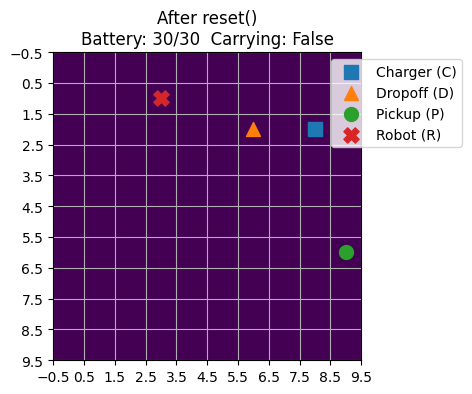

In [ ]:
#test
import matplotlib.pyplot as plt
import numpy as np

def plot_env(env, title="RoboCourier"):
    gs = env.grid_size

    fig, ax = plt.subplots(figsize=(4, 4))
    board = np.zeros((gs, gs))
    ax.imshow(board, extent=(-0.5, gs-0.5, -0.5, gs-0.5))

    ax.set_xticks(np.arange(-0.5, gs, 1))
    ax.set_yticks(np.arange(-0.5, gs, 1))
    ax.grid(True)
    ax.set_xlim(-0.5, gs-0.5)
    ax.set_ylim(-0.5, gs-0.5)
    ax.invert_yaxis()

    ax.scatter([env.cx], [env.cy], s=100, marker="s", label="Charger (C)")
    ax.scatter([env.dx], [env.dy], s=100, marker="^", label="Dropoff (D)")
    ax.scatter([env.px], [env.py], s=100, marker="o", label="Pickup (P)")
    ax.scatter([env.rx], [env.ry], s=120, marker="X", label="Robot (R)")

    ax.set_title(f"{title}\nBattery: {env.battery}/{env.cfg.battery_max}  Carrying: {env.has_package}")
    ax.legend(loc="upper right", bbox_to_anchor=(1.35, 1.0))
    plt.show()
# test
env = RoboCourierEnv()
env.reset()
plot_env(env, "After reset()")

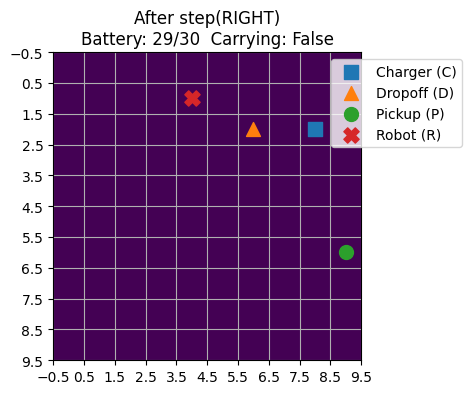

In [ ]:
env.step(3)  # 3 = RIGHT
plot_env(env, "After step(RIGHT)")

In [ ]:
## animate

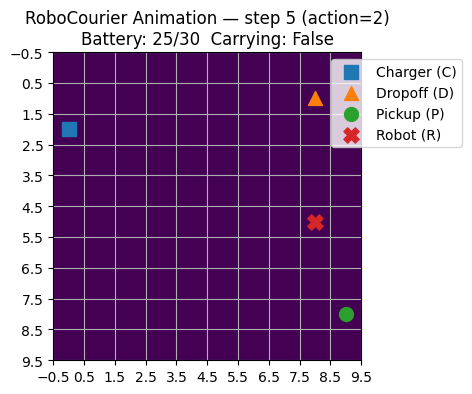

None

In [ ]:
# Mini animation using a fixed list of actions
import time
from IPython.display import clear_output, display

def animate_actions(env, actions, delay=0.4, title="RoboCourier Animation"):
    """Animate the env for a sequence of actions."""
    #  fresh
    env.reset()
    clear_output(wait=True)
    plot_env(env, f"{title} — start")
    display(None)
    time.sleep(delay)

    for i, a in enumerate(actions, 1):
        env.step(a)
        clear_output(wait=True)
        plot_env(env, f"{title} — step {i} (action={a})")
        display(None)
        time.sleep(delay)
env = RoboCourierEnv()
animate_actions(env, actions=[3,3,1,1,2], delay=0.5)

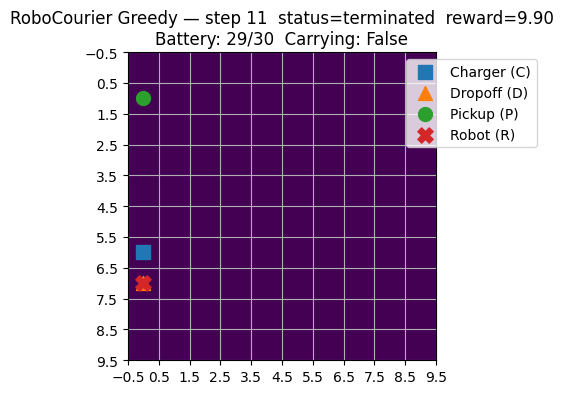

None

In [ ]:
import time
from IPython.display import clear_output, display
# 0=UP, 1=DOWN, 2=LEFT, 3=RIGHT
def greedy_action_toward(env, tx, ty):
    """Choose a 1-step move that reduces Manhattan distance to (tx, ty)."""
    # current pos
    x, y = env.rx, env.ry
    if x < tx:  return 3  # RIGHT
    if x > tx:  return 2  # LEFT
    if y < ty:  return 1  # DOWN
    if y > ty:  return 0  # UP
    return 0
def animate_greedy_delivery(env, max_steps=200, delay=0.35, title="RoboCourier Greedy"):
    env.reset()
    steps = 0
    clear_output(wait=True)
    plot_env(env, f"{title} — start")
    display(None)
    time.sleep(delay)

    while steps < max_steps:
        # target: go to pickup if not carrying; otherwise to dropoff
        if not env.has_package:
            tx, ty = env.px, env.py
        else:
            tx, ty = env.dx, env.dy

        action = greedy_action_toward(env, tx, ty)
        obs, reward, terminated, truncated, _ = env.step(action)

        steps += 1
        clear_output(wait=True)
        status = "terminated" if terminated else ("truncated" if truncated else "running")
        plot_env(env, f"{title} — step {steps}  status={status}  reward={reward:.2f}")
        display(None)
        time.sleep(delay)

        if terminated or truncated:
            break

env = RoboCourierEnv()
animate_greedy_delivery(env, delay=0.4)